# Import Modules

In [106]:
import os
import matplotlib.pyplot as plt
from collections import Counter

import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim

from PIL import Image
import xmltodict


In [107]:
print("PyTorch Version: ",torch.__version__)


PyTorch Version:  1.10.2


In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device 

device(type='cuda')

# Load the dataset


In [110]:
img_names=[] 
xml_names=[] 
for dirname, _, filenames in os.walk('./dataset/'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)

In [111]:
path_annotations="./dataset/annotations/" 
listing=[]
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])
        

Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n',values)

dict_keys(['without_mask', 'with_mask', 'mask_weared_incorrect']) 
 dict_values([717, 3232, 123])


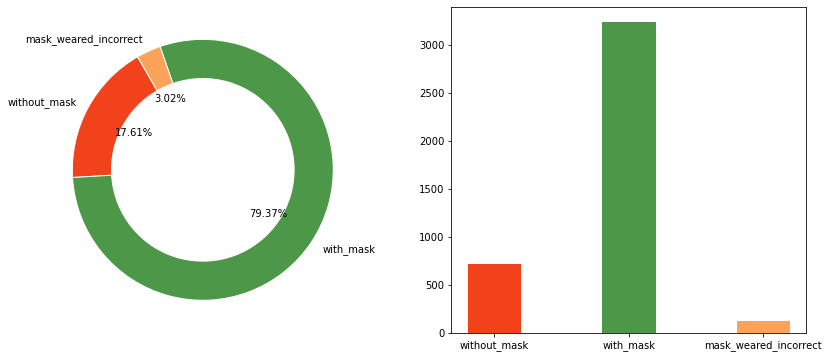

In [112]:
colors = ['#f1421b','#4d9748','#fda25a']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = 'w'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%', colors=colors)

ax2 = plt.bar(Items, list(values),
              color=colors ,width = 0.4)

plt.show()

Dataset contains images :

with_mask : 79.37% mask_weared_incorrect : 3.02% without_mask : 17.61%

In [113]:
options={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2} 

In [114]:
path_image="./dataset/images/"  


In [115]:
def dataset_creation(image_list): 
    image_tensor=[]
    label_tensor=[]
    for i,j in enumerate(image_list):
        with open(path_annotations+j[:-4]+".xml") as fd:
            doc=xmltodict.parse(fd.read())
        if type(doc["annotation"]["object"])!=list:
            temp=doc["annotation"]["object"]
            x,y,w,h=list(map(int,temp["bndbox"].values()))
            label=options[temp["name"]]
            image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
        else:
            temp=doc["annotation"]["object"]
            for k in range(len(temp)):
                x,y,w,h=list(map(int,temp[k]["bndbox"].values()))
                label=options[temp[k]["name"]]
                image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"),y,x,h-y,w-x)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))
                
    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)


my_transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])

mydataset=dataset_creation(img_names)

In [116]:
mydataset[0]


[tensor([[[0.4941, 0.4941, 0.4941,  ..., 0.6157, 0.6157, 0.6157],
          [0.4941, 0.4941, 0.4941,  ..., 0.6157, 0.6157, 0.6157],
          [0.4941, 0.4941, 0.4941,  ..., 0.6157, 0.6157, 0.6157],
          ...,
          [0.1843, 0.1843, 0.1843,  ..., 0.3216, 0.3216, 0.3216],
          [0.1843, 0.1843, 0.1843,  ..., 0.3216, 0.3216, 0.3216],
          [0.1843, 0.1843, 0.1843,  ..., 0.3216, 0.3216, 0.3216]],
 
         [[0.4431, 0.4431, 0.4431,  ..., 0.5216, 0.5216, 0.5216],
          [0.4431, 0.4431, 0.4431,  ..., 0.5216, 0.5216, 0.5216],
          [0.4431, 0.4431, 0.4431,  ..., 0.5216, 0.5216, 0.5216],
          ...,
          [0.1216, 0.1216, 0.1216,  ..., 0.1647, 0.1647, 0.1647],
          [0.1216, 0.1216, 0.1216,  ..., 0.1647, 0.1647, 0.1647],
          [0.1216, 0.1216, 0.1216,  ..., 0.1647, 0.1647, 0.1647]],
 
         [[0.4784, 0.4784, 0.4784,  ..., 0.5216, 0.5216, 0.5216],
          [0.4784, 0.4784, 0.4784,  ..., 0.5216, 0.5216, 0.5216],
          [0.4784, 0.4784, 0.4784,  ...,

In [117]:
train_size= int(len(mydataset)*0.8)
test_size= len(mydataset)-train_size
print('Length of dataset is', len(mydataset), '\nLength of training set is :',train_size,'\nLength of test set is :', test_size)

Length of dataset is 4072 
Length of training set is : 3257 
Length of test set is : 815


In [118]:
trainset,testset=torch.utils.data.random_split(mydataset,[train_size,test_size])
